# **Lesson 04**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# plot parameters
import sys
sys.path.append('./../Libraries/')
import plt_params
%matplotlib inline

# Exercise 04.1

The NSL_SIMULATOR code we have provided compute the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, and the temperature, $T$.

Include the calculation of the pressure, $P$, inside your Molecular Dynamics code: block averages, progressive average values and progressive uncertainties.

Remember that, via the **virial theorem**, the pressure in a Lennard-Jones system can be estimated by means of:

$$ P = \rho k_B \langle T \rangle + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\varepsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle $$

## Solution
The simulator given in this exercise is capable to perform various experiments: two types of **Lennard-Jones** simulation, in the microcanonical (NVE) and in the canonical (NVT) ensembles, and two types of one dimensional **Ising models**, which exploits Metropolis and Gibbs algorithms to evolve the system.

### Microcanonical ensamble
In this exercise we focus on the Lennard-Jones molecular dynamic simulation in the microcanonical ensemble: the system is characterized by a fixed value of **Number of particles** $N$, **volume** $V$ and **total energy** $E$. In other words, the microcanonical ensemble models a system isolated from the thermodynamic universe: it does not exchange neither energy nor particles with the environment. In this scenario, every microstate (i.e. every point in the phase space) has the same probability to be observed, and this is the so called postulate of "equal a priori probabilities".

### Verlet's algorithm
This algorithm is commonly used in molecular dynamic simulations and it is used also in this simulator to perform a dynamic steps. It is derived from two third-order Taylor expansions of the particle position $\vec{r}$ in $t + \delta t$ and in $t - \delta t$, summed together to obtain:

$$ \vec r(t + \delta t) \simeq 2 \vec r(t) - \vec r(t - \delta t) + \vec a(t) \delta t^2 \ . $$

where $\vec a(t)$ is the particle acceleration. Some notes abouth this algorithm:
- it is a two-step method: it computes $\vec r(t + \delta t)$ knowing the two positions $\vec r(t)$ and $\vec r(t - \delta t)$
- it is time-reversible
- it does not use the velocity to compute the new position
- it conserves the energy even for long simulation times

In a molecular dynamic simulation every particle is evolved independently along its trajectory: it means that we compute the force acting on each particle and we know exactly positions and velocities of all the particles of the system. This is a practically unreachable knowledge if we consider a real experiment, so to compare the simulation results to reality we need to compute some macroscopical or measurable quantities, such for example temperature and pressure.

### Periodic Boundary Conditions
Statistical mechanics studies systems with huge quantities of particles, about $N = 10^{23}$: because in the simulation we should compute the trajectory for every particle, it would be too computationally expensive to simulate the whole system. To avoid this, we use a small number of particles (e.g. $N^*=100$) and apply the **Periodic Boundary Conditions** PBC: our particles live in a box of volume $V^*$, chose to obtain the same density of the simulated system, $\rho = N/V = N^*/V^*$. This box is repeated an indefinite number of times in the space, potentially to infinite.

Another reason to implement the simulation on a small system and then to apply PBC is that usually we are interested in the behavoiur of the system bulk, while the surface effects are usually negligible in a real system. So, using PBC we are able to simulate an infinite system with no edges.

Also, usually the potential between particles has a long range interaction, and in simulations it is useful to introduce a **cut-off** radius, over which the potential is set to zero to avoid too much computational effort.



### Code

##### Input parameters
The simulator initialize itself taking some external inputs. The main input file is `INPUT/input.dat`, and its parameters are:

>SIMULATION_TYPE    $\hspace{10mm}$     0/1/2/3 \<double\> \<double\>
><br>TEMP           $\hspace{28.4mm}$   \<double\>
><br>RESTART        $\hspace{23.5mm}$   0/1
><br>NPART          $\hspace{26.5mm}$   \<int\>
><br>RHO            $\hspace{29.5mm}$   \<double\>
><br>R_CUT          $\hspace{26.3mm}$   \<double\>
><br>DELTA          $\hspace{27.2mm}$   \<double\>
><br>NBLOCKS        $\hspace{22.5mm}$   \<int\>
><br>NSTEPS         $\hspace{24.7mm}$   \<int\>
><br>
><br>ENDINPUT

- SIMULATION_TYPE:
    - 0: LJ molecular dynamics (NVE)
    - 1: LJ Monte Carlo (NVT)
    - 2: Ising 1D Monte Carlo (M(RT)^2)
    - 3: Ising 1D Monte Carlo (GIBBS)
    - \<double\> _J: Ising hamiltonian parameter
    - \<double\> _H: external field
- TEMP: input temperature value in reduced units, used to initialize the velocities
- RESTART:
    - 0: does not perform the restarting of the system
    - 1: perform the restarting of the system
- NPART: number of particles (here 108)
- RHO: density of the system
- R_CUT: cut-off radius
- DELTA: 
    - if SIMULATION_TYPE = 0/1: Verlet step length
    - if SIMULATION_TYPE = 2: M(RT)^2 step length
- NBLOCKS: number of blocks 
- NSTEPS: steps in each block
- ENDINPUT: flag used to identify the end of the inputs to read


---

In file `properties.dat` there are written all physical observables that have to be measured during the simulation:
- TOTAL_ENERGY
- POTENTIAL_ENERGY
- KINETIC_ENERGY
- TEMPERATURE
- PRESSURE
- GOFR $\hspace{10mm}$ \<int\> n_bins
- MAGNETIZATION
- SPECIFIC_HEAT
- SUSCEPTIBILITY


---

In the `INPUT/CONFIG` folder, there are also files that can be read the initial configuration of velocities, positions (as a crystal) and spins.

#### Outputs
The simulator produces several output files `.csv` in which there are the progressive (blocking) values of the quantities the simulation has measured, an output summary `output.csv`, an equilibration summary `equilibration.csv` and the `seed.out`.

The data concerning the equilibration are stored in the `OUTPUT/EQUILIBRATION` directory.

#### Pressure calculation

To calculate the pressure we firstly have to convert all the units to reduced units, using $\sigma$ as unit of length, $\varepsilon$ as unit of energy and $m$ as unit of mass. In reduced units, the pressure formula becomes:

$$ P^\star = \rho^\star T^\star + \frac{48}{3V^\star} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N \left[ \left(r^\star_{ij}\right)^{-12} - \left(r^\star_{ij}\right)^{-6} \right] \right\rangle \ , $$

where the $^*$ denotes reduced units. These units of measure are very powerful because using them a lot of diverse physical systems with different parameters (such as $\rho$, $T$ and $r_{cut}$) fall into the same equivalence class and can be simulated exploiting just one combination of parameters in reduces units. Also, reduced units help to prevent representation problems of very large or very small numbers, due to the computer finite memory.

Here I show the code that measures the pressure:

```c++
  double pressure_temp=0.0;
  /* ... */
  if(dr < _r_cut){
    if (_measure_penergy)   penergy_temp += 1.0/pow(dr,12) - 1.0/pow(dr,6); // POTENTIAL ENERGY
    if (_measure_pressure) pressure_temp += 1.0/pow(dr,12) - 0.5/pow(dr,6); // PRESSURE
  }
  /* ... */
  // PRESSURE //////////////////////////////////////////////////////////////////
  if (_measure_pressure){
    if (!_measure_temp){
      cerr << "PROBLEM: pressure needs to measure also the temperature!" << endl;
      exit(EXIT_FAILURE);
    }
    _measurement(_index_pressure) = _ptail + _rho * _measurement(_index_temp) + 48.0 * pressure_temp / (3.0 * _volume * double(_npart));
  }  
```

# Exercise 04.2

By means of your upgraded code, perform MD simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

and show in pictures the obtained progressive average values and uncertainties as a functions of the increasing number of blocks for the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, the temperature, $T$, and the pressure, $P$, in reduced units!

**Equilibration is needed!**

By monitoring the temperature, $T$, during the first time steps of the simulation, you will observe that at the beginning, starting from a perfect crystalline configuration, $T$ will not conserve its value. Can you understand and explain this behaviour?

Explore and find the starting value of $T$ needed to stabilize, after a certain number of time steps (equilibration time), the average value of $T$ on the desired $T^\star$. Perform your solid/liquid/gas phase MD simulations by re-starting them after such equilibration time.

## Solution

Please note that the simulator code already implements also the correct values of `_ptail` and `_vtail`, so the results may be slightly different from the expected ones.

### Equilibration

We want to perform experiments on the system at equilibrium, so, to avoid measurements of quantities initialized badly that are far from their equilibrium value, and that would therefore spoil the blocking average, it is necessary to equilibrate the system before starting the real simulation.

The equilibration of the system is performed in the `equilibration()` method: it consists in the research of the best input value for the temperature to reach, at the equilibrium, the target temperature. At first, the system sets the target temperature equal to the one it has read from file `input.dat` in the initialization, then loops over the number of blocks and of steps per block (the parameters `NBLOCKS` and `NSTEPS` of the initialization) calling `measure()` and `averages()` like a normal simulation. The measured value of $T$ is then compared with the target one, and if $T_{meas} < T_{targ}$ then input temperature is increased, or else reduced. This loop goes on until the output temperature is equal to the desired equilibrium temperature, given a tolerance of $3\sigma_T$, where $\sigma_T$ is the error of the calculated temperature. The correction factor reduces every time that the cycle restarts.

The data of the equilibration measurements are stored in `OUTPUT/EQUILIBRATION` directory. Here I show the code for equilibration:
```c++
do {
      if(temp_target/double(div) < sigma) corr = sigma;
      else corr = temp_target/double(div);

      if(val != 0.0 and val < temp_target) _temp = temp + corr;
      else if(val != 0.0 and val > temp_target) _temp = temp - corr;
      temp = _temp;
      div *= 2;

      this->read_configuration(path);
      this->initialize_velocities(path);
      this->initialize_properties(path);
      this->block_reset(0);

      fmt::print("\nInitial temperature: {:.3f}\n", _temp);
      coutf << "Initial temperature: " << _temp << endl;
      
      for(int i=0; i<_nblocks; i++) {
        for(int j=0; j<_nsteps; j++) {
          Progress_Bar(i*_nsteps + j, _nblocks*_nsteps -1);
          this->step();
          this->measure();
        }
        this->averages(i+1, path);
        this->block_reset(i+1, path);
      }

      val = _global_av(_index_temp)/double(_nblocks);
      sigma = this->error(_global_av(_index_temp), _global_av2(_index_temp), _nblocks);


      fmt::print("\nMeasured T*: {:.5f} ± {:.5f}\tTarget T*: {:.3f}\n", val, sigma, temp_target); 
      coutf << "\tMeasured T*: " << val << " ± " << sigma << "\tTarget T*: " << temp_target << endl;

    } while(temp_target < val - 3.0*sigma or temp_target > val + 3.0*sigma);
```

Here I have done the equilibration with one executable (in directory `04.2/<Phase>/Equilibration`), then I restarted the system to do the simulation

In [3]:
eq_solid = np.loadtxt('04.2/Solid/Equilibration/OUTPUT/EQUILIBRATION/temperature_H=0.00_t=1.541.csv', delimiter=',', skiprows=1)
eq_liquid = np.loadtxt('04.2/Liquid/Equilibration/OUTPUT/EQUILIBRATION/temperature_H=0.00_t=1.985.csv', delimiter=',', skiprows=1)
eq_gas = np.loadtxt('04.2/Gas/Equilibration/OUTPUT/EQUILIBRATION/temperature_H=0.00_t=0.956.csv', delimiter=',', skiprows=1)

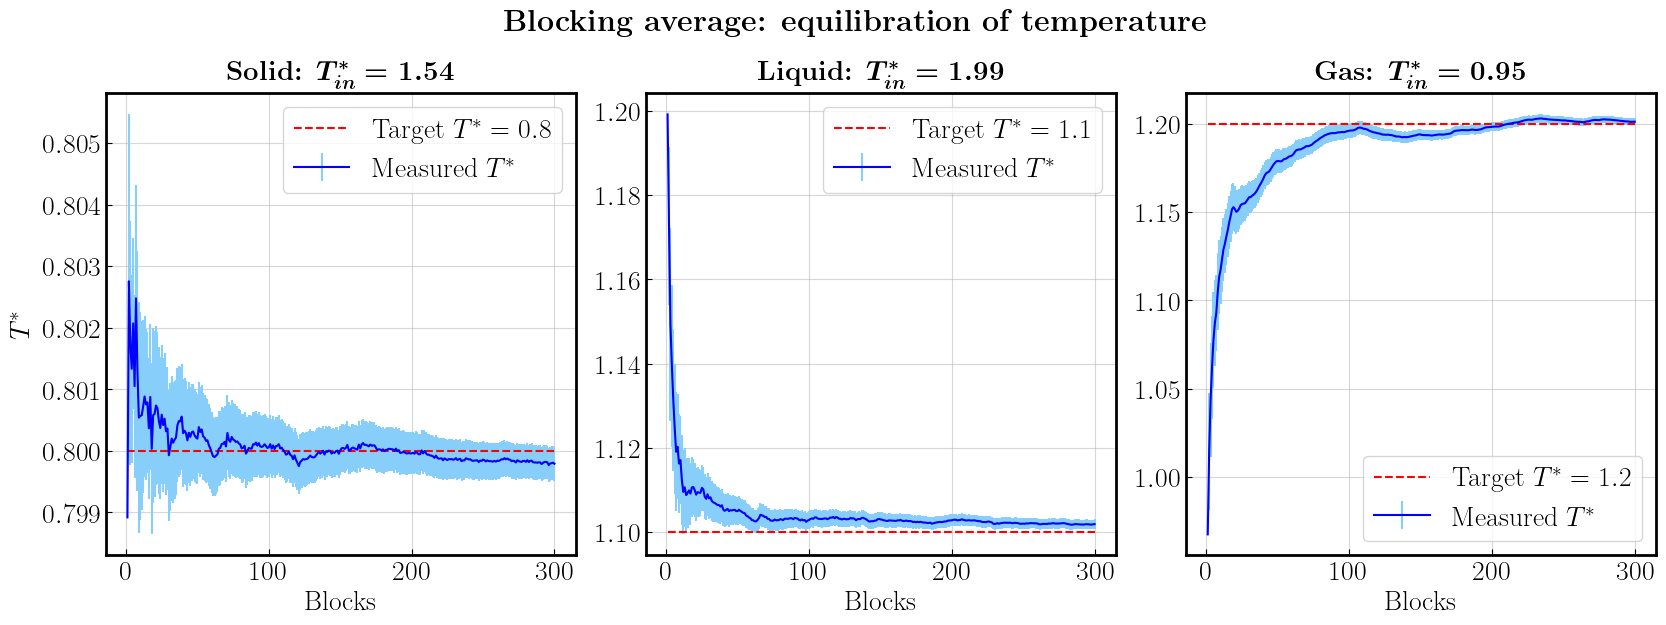

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(20,6), gridspec_kw={'wspace': 0.15})

# solid
axs[0].errorbar(eq_solid[:,0], eq_solid[:,2], yerr=eq_solid[:,3], color='blue', ecolor='lightskyblue', label='Measured $T^*$')
t_solid = np.ones(eq_solid.shape[0])*0.8
axs[0].plot(eq_solid[:,0], t_solid, linestyle='--', color='red', label='Target $T^* = 0.8$')

axs[0].set_title(r'\boldmath \textbf{Solid: $T^*_{in} = 1.54$}', pad=10)
axs[0].set_xlabel('Blocks')
axs[0].set_ylabel('$T^*$', labelpad=6)
axs[0].legend()


# liquid
axs[1].errorbar(eq_liquid[:,0], eq_liquid[:,2], yerr=eq_liquid[:,3], color='blue', ecolor='lightskyblue', label='Measured $T^*$')
t_liquid = np.ones(eq_liquid.shape[0])*1.1
axs[1].plot(eq_liquid[:,0], t_liquid, linestyle='--', color='red', label='Target $T^* = 1.1$')

axs[1].set_title(r'\boldmath \textbf{Liquid: $T^*_{in} = 1.99$}', pad=10)
axs[1].set_xlabel('Blocks')
axs[1].legend()


# gas
axs[2].errorbar(eq_gas[:,0], eq_gas[:,2], yerr=eq_gas[:,3], color='blue', ecolor='lightskyblue', label='Measured $T^*$')
t_gas = np.ones(eq_gas.shape[0])*1.2
axs[2].plot(eq_gas[:,0], t_gas, linestyle='--', color='red', label='Target $T^* = 1.2$')

axs[2].set_title(r'\boldmath \textbf{Gas: $T^*_{in} = 0.95$}', pad=10)
axs[2].set_xlabel('Blocks')
axs[2].legend()

fig.suptitle(r'\textbf{Blocking average: equilibration of temperature}', y=1.02, fontsize=22)
plt.show()

This plots show the equilibration of solid, liquid and gas phases: after $300$ blocks the values are compatible with the target ones within $3 \sigma$.

**Plot parameters**:
- Solid:
    - Total steps: $10^4$
    - Blocks: $50$
    - Steps in each block: $200$
- Liquid:
    - Total steps: $2\times10^4$
    - Blocks: $100$
    - Steps in each block: $200$
- Gas:    
    - Total steps: $2\times10^5$
    - Blocks: $200$
    - Steps in each block: $10^3$

### Simulation

In [5]:
# solid
energy_solid = np.loadtxt('04.2/Solid/Simulation/OUTPUT/total_energy.csv', delimiter=',', skiprows=1)
potential_solid = np.loadtxt('04.2/Solid/Simulation/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
kinetic_solid = np.loadtxt('04.2/Solid/Simulation/OUTPUT/kinetic_energy.csv', delimiter=',', skiprows=1)
temperature_solid = np.loadtxt('04.2/Solid/Simulation/OUTPUT/temperature.csv', delimiter=',', skiprows=1)
pressure_solid = np.loadtxt('04.2/Solid/Simulation/OUTPUT/pressure.csv', delimiter=',', skiprows=1)

# liquid
energy_liquid = np.loadtxt('04.2/Liquid/Simulation/OUTPUT/total_energy.csv', delimiter=',', skiprows=1)
potential_liquid = np.loadtxt('04.2/Liquid/Simulation/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
kinetic_liquid = np.loadtxt('04.2/Liquid/Simulation/OUTPUT/kinetic_energy.csv', delimiter=',', skiprows=1)
temperature_liquid = np.loadtxt('04.2/Liquid/Simulation/OUTPUT/temperature.csv', delimiter=',', skiprows=1)
pressure_liquid = np.loadtxt('04.2/Liquid/Simulation/OUTPUT/pressure.csv', delimiter=',', skiprows=1)

# gas
energy_gas = np.loadtxt('04.2/Gas/Simulation/OUTPUT/total_energy.csv', delimiter=',', skiprows=1)
potential_gas = np.loadtxt('04.2/Gas/Simulation/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
kinetic_gas = np.loadtxt('04.2/Gas/Simulation/OUTPUT/kinetic_energy.csv', delimiter=',', skiprows=1)
temperature_gas = np.loadtxt('04.2/Gas/Simulation/OUTPUT/temperature.csv', delimiter=',', skiprows=1)
pressure_gas = np.loadtxt('04.2/Gas/Simulation/OUTPUT/pressure.csv', delimiter=',', skiprows=1)

In [6]:
solid = [energy_solid, potential_solid, kinetic_solid, temperature_solid, pressure_solid]
liquid = [energy_liquid, potential_liquid, kinetic_liquid, temperature_liquid, pressure_liquid]
gas = [energy_gas, potential_gas, kinetic_gas, temperature_gas, pressure_gas]

data = [solid, liquid, gas]
property = ['Total energy', 'Potential energy', 'Kinetic energy', 'Temperature', 'Pressure']
phase = [r'\textbf{Solid}', r'\textbf{Liquid}', r'\textbf{Gas}']

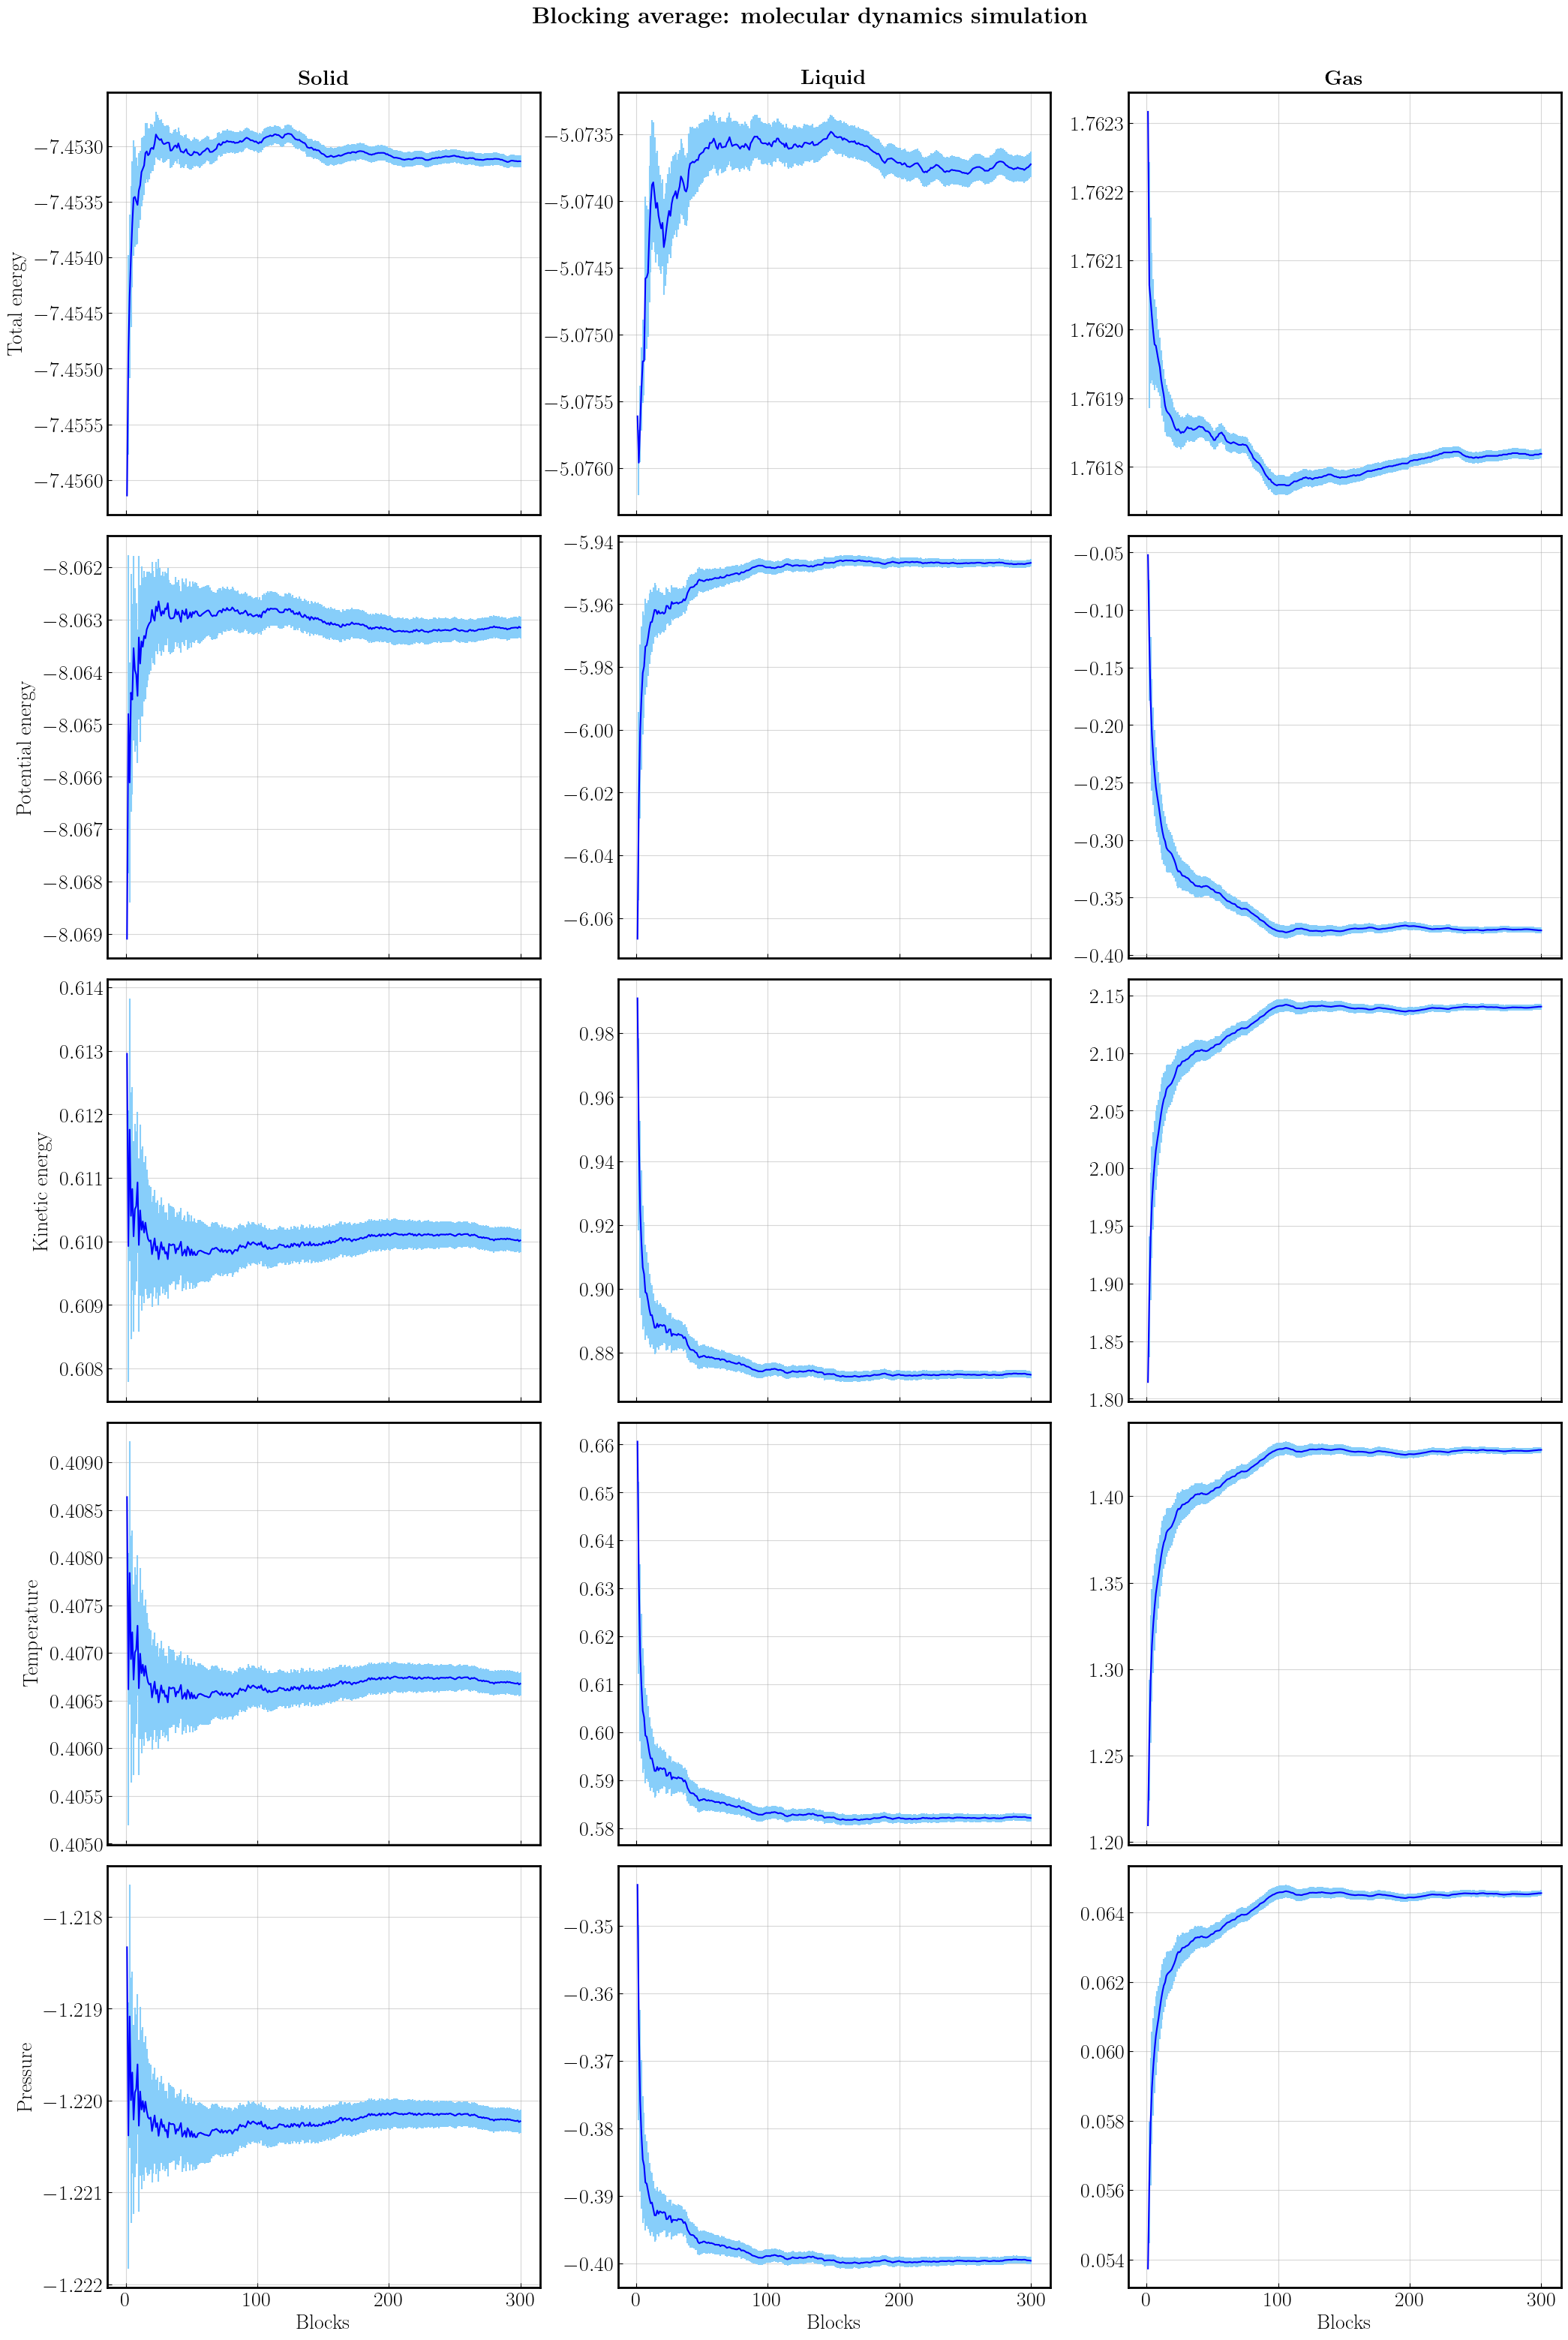

In [7]:
fig, axs = plt.subplots(5, 3, figsize=(25,38), gridspec_kw={'wspace': 0.18, 'hspace': 0.05})

for i in range(3) :
    for j in range(5) :
        axs[j,i].errorbar(data[i][j][:,0], data[i][j][:,2], yerr=data[i][j][:,3], color='blue', ecolor='lightskyblue')
        axs[j,0].set_ylabel(property[j], labelpad=8)
        axs[j,i].set_xticklabels([])
    axs[0,i].set_title(phase[i], pad=8)
    axs[-1,i].set_xticks([0,100,200,300], ['0','100','200','300'])
    axs[-1,i].set_xlabel('Blocks')


fig.suptitle(r'\textbf{Blocking average: molecular dynamics simulation}', y=0.91, fontsize=22)
plt.show()

These plots show the outputs of the simulation, performed restarting the system after the equilibration phase.

**Plot parameters** (all phases):
- Total steps: $10^5$
- Blocks: $100$
- Steps in each block: $10^3$

### Equilibration + Simulation ('Both')

Here I have done the equilibration and immediatly after the simulation, without restarting the system.

In [8]:
eq_solid_b = np.loadtxt('04.2/Solid/Both/OUTPUT/EQUILIBRATION/temperature_H=0.00_t=1.541.csv', delimiter=',', skiprows=1)
eq_liquid_b = np.loadtxt('04.2/Liquid/Both/OUTPUT/EQUILIBRATION/temperature_H=0.00_t=1.985.csv', delimiter=',', skiprows=1)
eq_gas_b = np.loadtxt('04.2/Gas/Both/OUTPUT/EQUILIBRATION/temperature_H=0.00_t=0.952.csv', delimiter=',', skiprows=1)

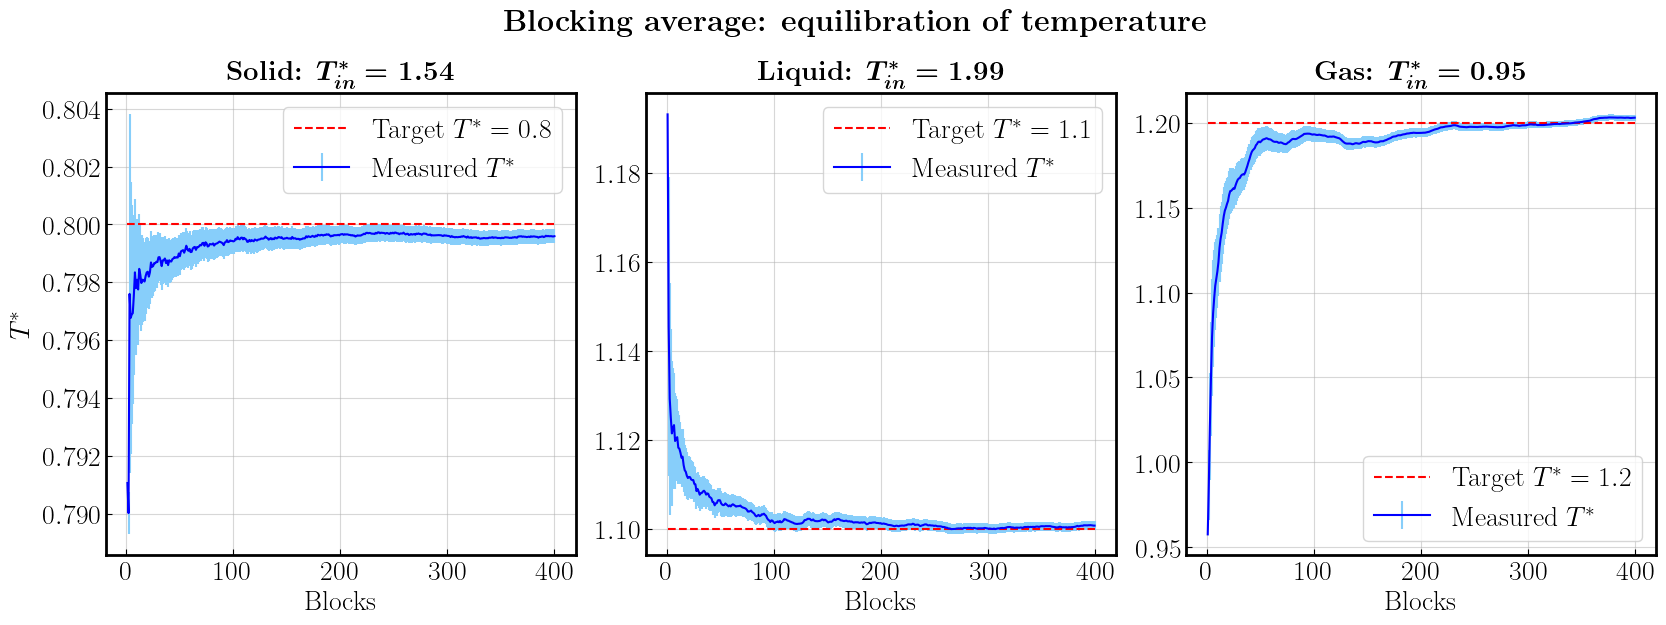

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(20,6), gridspec_kw={'wspace': 0.15})

# solid
axs[0].errorbar(eq_solid_b[:,0], eq_solid_b[:,2], yerr=eq_solid_b[:,3], color='blue', ecolor='lightskyblue', label='Measured $T^*$')
t_solid = np.ones(eq_solid_b.shape[0])*0.8
axs[0].plot(eq_solid_b[:,0], t_solid, linestyle='--', color='red', label='Target $T^* = 0.8$')

axs[0].set_title(r'\boldmath \textbf{Solid: $T^*_{in} = 1.54$}', pad=10)
axs[0].set_xlabel('Blocks')
axs[0].set_ylabel('$T^*$', labelpad=6)
axs[0].legend()


# liquid
axs[1].errorbar(eq_liquid_b[:,0], eq_liquid_b[:,2], yerr=eq_liquid_b[:,3], color='blue', ecolor='lightskyblue', label='Measured $T^*$')
t_liquid = np.ones(eq_liquid_b.shape[0])*1.1
axs[1].plot(eq_liquid_b[:,0], t_liquid, linestyle='--', color='red', label='Target $T^* = 1.1$')

axs[1].set_title(r'\boldmath \textbf{Liquid: $T^*_{in} = 1.99$}', pad=10)
axs[1].set_xlabel('Blocks')
axs[1].legend()


# gas
axs[2].errorbar(eq_gas_b[:,0], eq_gas_b[:,2], yerr=eq_gas_b[:,3], color='blue', ecolor='lightskyblue', label='Measured $T^*$')
t_gas = np.ones(eq_gas_b.shape[0])*1.2
axs[2].plot(eq_gas_b[:,0], t_gas, linestyle='--', color='red', label='Target $T^* = 1.2$')

axs[2].set_title(r'\boldmath \textbf{Gas: $T^*_{in} = 0.95$}', pad=10)
axs[2].set_xlabel('Blocks')
axs[2].legend()

fig.suptitle(r'\textbf{Blocking average: equilibration of temperature}', y=1.02, fontsize=22)
plt.show()

**Plot parameters**:
- Solid:
    - Total steps: $10^5$
    - Blocks: $100$
    - Steps in each block: $10^3$
- Liquid:
    - Total steps: $10^5$
    - Blocks: $100$
    - Steps in each block: $10^3$
- Gas:    
    - Total steps: $2\times10^5$
    - Blocks: $100$
    - Steps in each block: $10^4$

In [10]:
# solid
energy_solid_b = np.loadtxt('04.2/Solid/Both/OUTPUT/total_energy.csv', delimiter=',', skiprows=1)
potential_solid_b = np.loadtxt('04.2/Solid/Both/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
kinetic_solid_b = np.loadtxt('04.2/Solid/Both/OUTPUT/kinetic_energy.csv', delimiter=',', skiprows=1)
temperature_solid_b = np.loadtxt('04.2/Solid/Both/OUTPUT/temperature.csv', delimiter=',', skiprows=1)
pressure_solid_b = np.loadtxt('04.2/Solid/Both/OUTPUT/pressure.csv', delimiter=',', skiprows=1)

# liquid
energy_liquid_b = np.loadtxt('04.2/Liquid/Both/OUTPUT/total_energy.csv', delimiter=',', skiprows=1)
potential_liquid_b = np.loadtxt('04.2/Liquid/Both/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
kinetic_liquid_b = np.loadtxt('04.2/Liquid/Both/OUTPUT/kinetic_energy.csv', delimiter=',', skiprows=1)
temperature_liquid_b = np.loadtxt('04.2/Liquid/Both/OUTPUT/temperature.csv', delimiter=',', skiprows=1)
pressure_liquid_b = np.loadtxt('04.2/Liquid/Both/OUTPUT/pressure.csv', delimiter=',', skiprows=1)

# gas
energy_gas_b = np.loadtxt('04.2/Gas/Both/OUTPUT/total_energy.csv', delimiter=',', skiprows=1)
potential_gas_b = np.loadtxt('04.2/Gas/Both/OUTPUT/potential_energy.csv', delimiter=',', skiprows=1)
kinetic_gas_b = np.loadtxt('04.2/Gas/Both/OUTPUT/kinetic_energy.csv', delimiter=',', skiprows=1)
temperature_gas_b = np.loadtxt('04.2/Gas/Both/OUTPUT/temperature.csv', delimiter=',', skiprows=1)
pressure_gas_b = np.loadtxt('04.2/Gas/Both/OUTPUT/pressure.csv', delimiter=',', skiprows=1)

In [11]:
solid_b = [energy_solid_b, potential_solid_b, kinetic_solid_b, temperature_solid_b, pressure_solid_b]
liquid_b = [energy_liquid_b, potential_liquid_b, kinetic_liquid_b, temperature_liquid_b, pressure_liquid_b]
gas_b = [energy_gas_b, potential_gas_b, kinetic_gas_b, temperature_gas_b, pressure_gas_b]

data_b = [solid_b, liquid_b, gas_b]
property = ['Total energy', 'Potential energy', 'Kinetic energy', 'Temperature', 'Pressure']
phase = [r'\textbf{Solid}', r'\textbf{Liquid}', r'\textbf{Gas}']

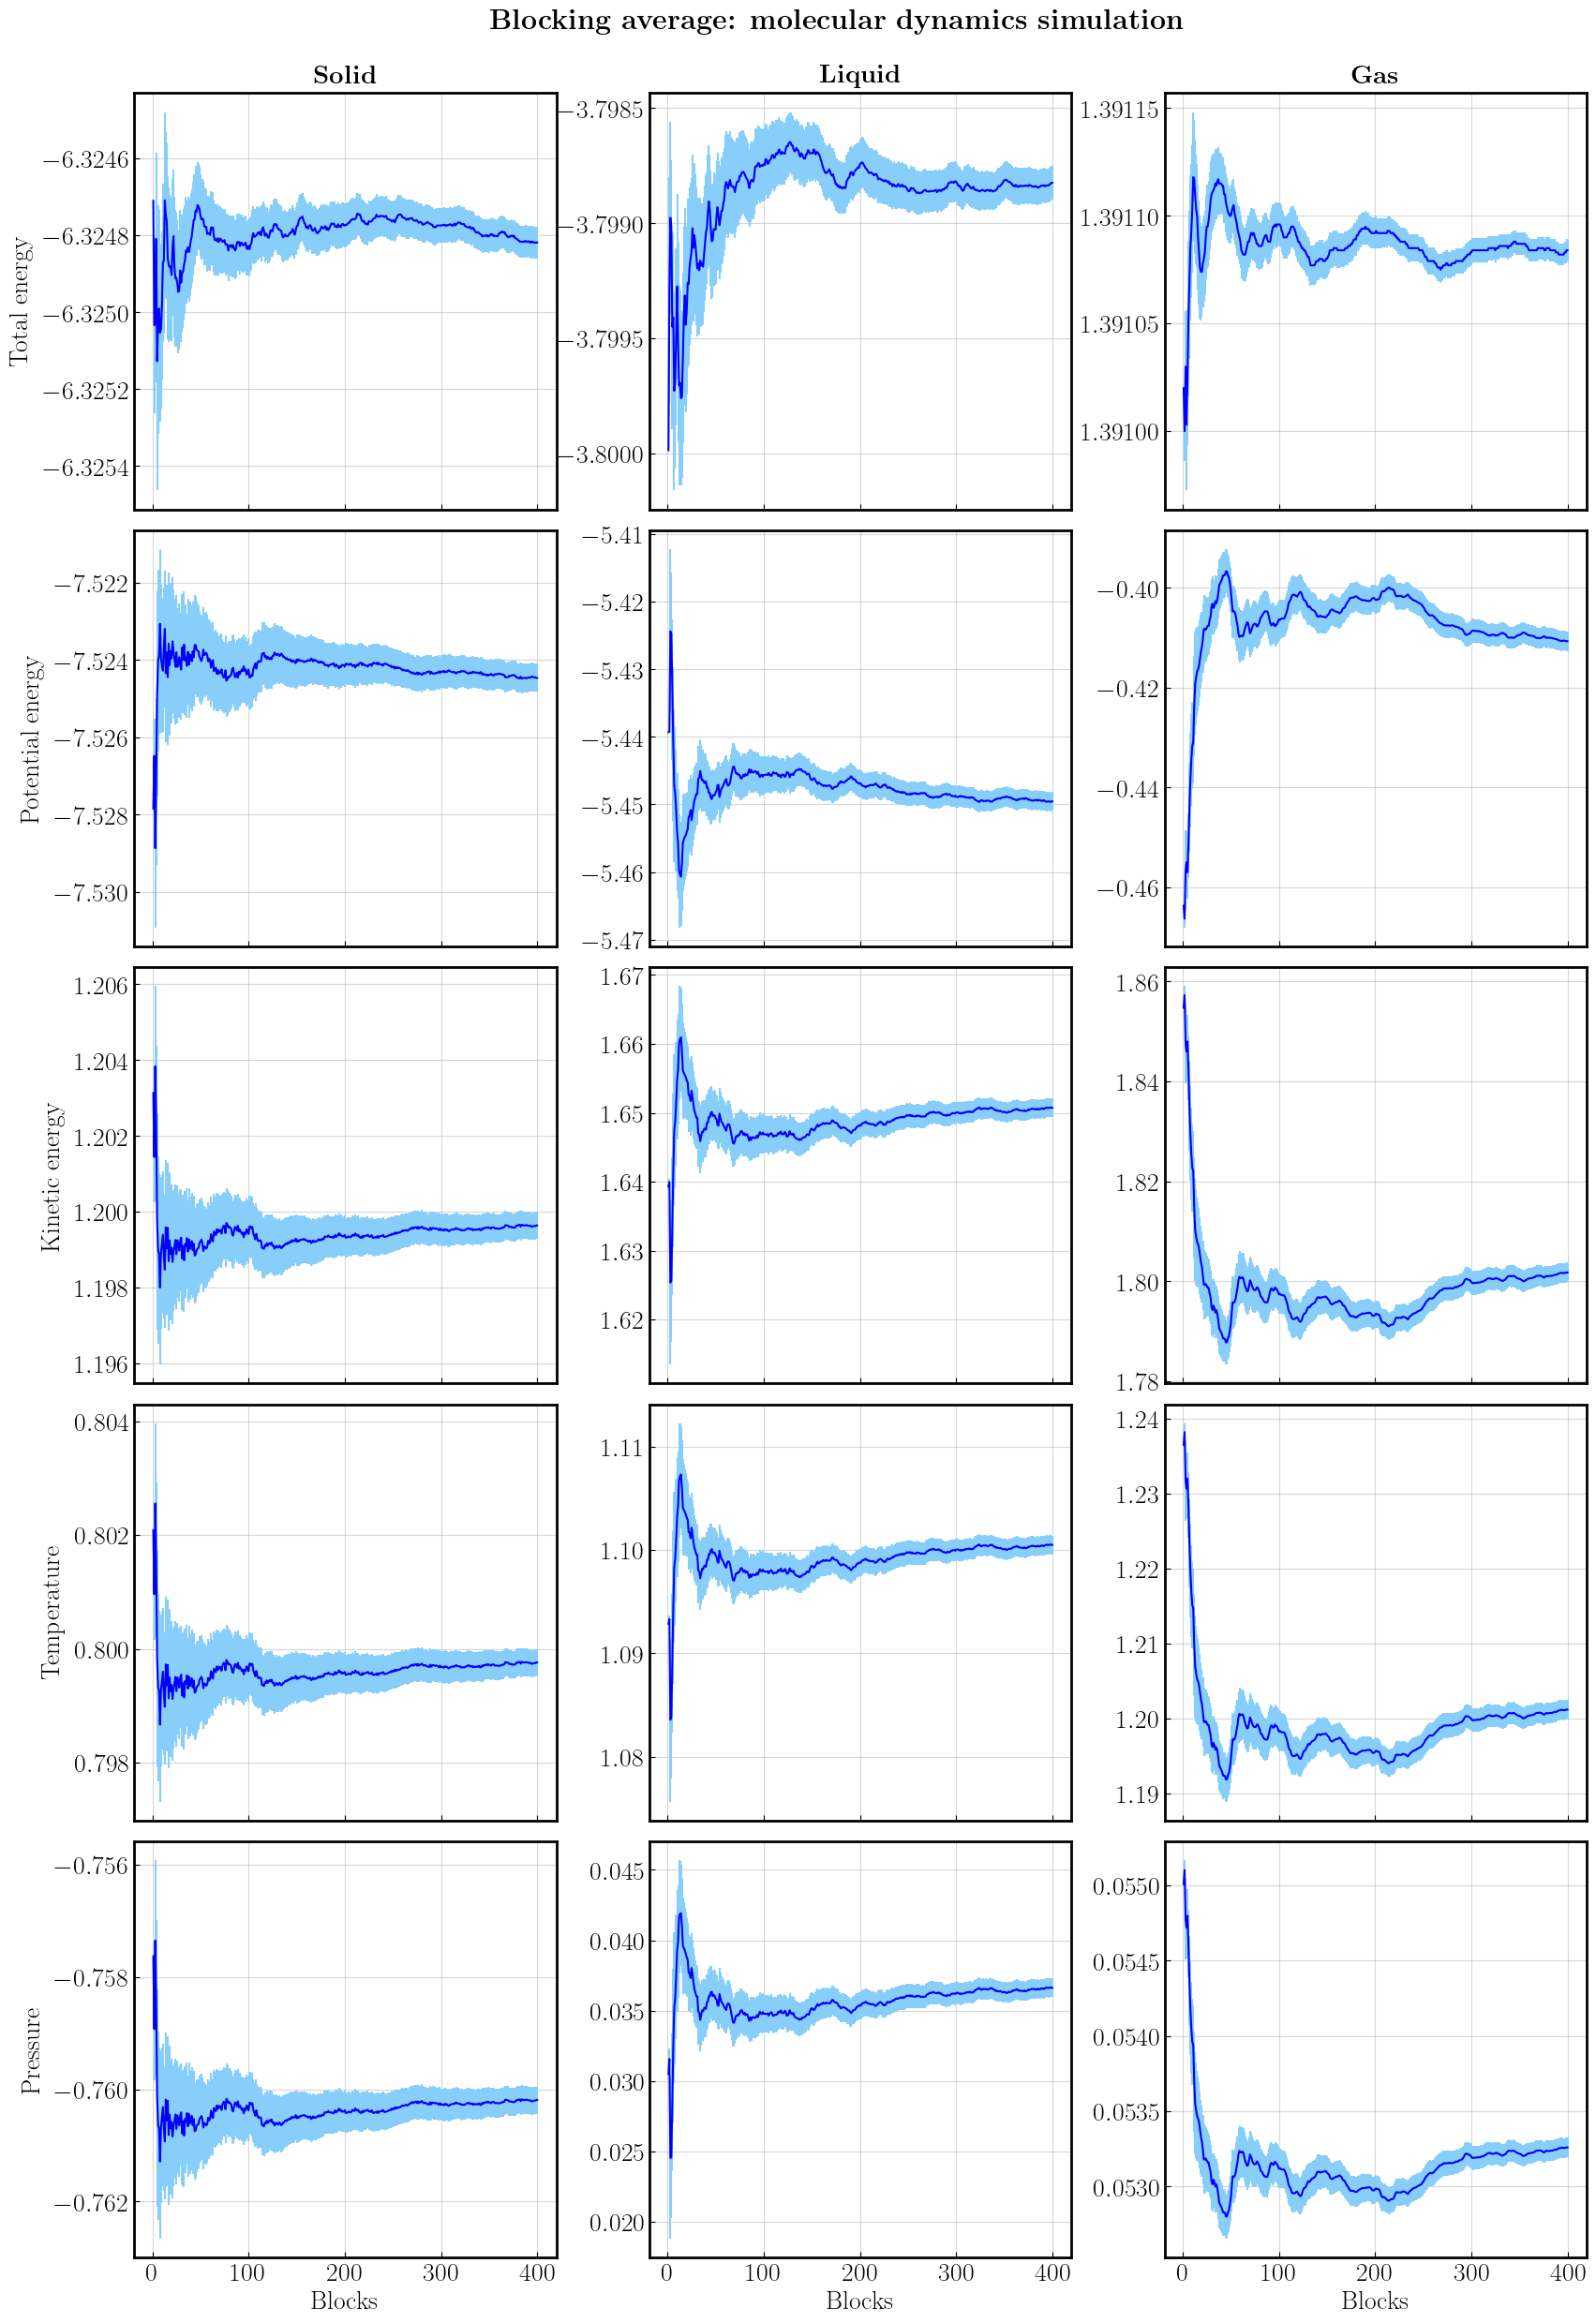

In [12]:
fig, axs = plt.subplots(5, 3, figsize=(20,30), gridspec_kw={'wspace': 0.22, 'hspace': 0.05})

for i in range(3) :
    for j in range(5) :
        axs[j,i].errorbar(data_b[i][j][:,0], data_b[i][j][:,2], yerr=data_b[i][j][:,3], color='blue', ecolor='lightskyblue')
        axs[j,0].set_ylabel(property[j], labelpad=8)
        axs[j,i].set_xticklabels([])
    axs[0,i].set_title(phase[i], pad=8)
    axs[-1,i].set_xticks([0,100,200,300,400], ['0','100','200','300','400'])
    axs[-1,i].set_xlabel('Blocks')


fig.suptitle(r'\textbf{Blocking average: molecular dynamics simulation}', y=0.91, fontsize=22)
plt.show()

**Plot parameters**:
- Solid:
    - Total steps: $10^5$
    - Blocks: $100$
    - Steps in each block: $10^3$
- Liquid:
    - Total steps: $10^5$
    - Blocks: $100$
    - Steps in each block: $10^3$
- Gas:    
    - Total steps: $2\times10^5$
    - Blocks: $100$
    - Steps in each block: $10^4$

## Observations
- Independently on how the simulation is done (separately from the equilibration or immediately after) the system seems to have reached the equilibrium, since the variation of its mean value in function of the number of blocks is always around the $1\%$ in the plots showed above. 
- The gas phase takes longer to get at the equilibrium, I expected that, because gas molecules have less interactions and so the system is slow to change its temperature and also the other quantities.
- The behaviour of the temperature and the kinetic energy is really similar, and this is coherent with their definitions.